* Equipo 7
* Simón Cuartas Rendón
* Camilo José Fúnez García
* Julián Ospina Murgueitio
* Deivid Zhang Figueroa
* Juliana Zuluaga Serna

# CLASIFICACIÓN DE IMÁGENES



## Objetivo

* En el siguiente proyecto se aborda el problema de crear un modelo para clasificar imágenes utilizando técnicas de aprendizaje estadístico, en este caso, una red neuronal convolucional.

## Materiales Principales

* Para la realización de este modelo, así como el planteamiento del modelo predictivo que se presentará más adelante se empleó la versión 3.6 de python y la plataforma Google Colaboratory, debido a la facilidad de trabajar con recursos como 25gb de memoria Ram y GPU, recursos computacionales muy beneficiosos al trabajar con imágenes.

* Conjunto De Entrenamiento: Este conjunto de datos es de un proyecto de Kaggle del curso T81-855: Aplicaciones de aprendizaje profundo en la Universidad de Washington en St. Louis. Para esta competencia, los estudiantes debían determinar si una persona usa anteojos o no. Sin embargo, sus sujetos de prueba no son personas reales. Una red neuronal adversa generativa (GAN) creó a todas las personas que ves en esta competencia. La red GAN crea estas imágenes usando un vector latente de 512 números. La asignación de Kaggle proporciona tanto los vectores latentes como las caras producidas por esos vectores. Ambos pueden serle útiles para clasificar si alguien lleva gafas o no. A este conjunto le corresponden 1505 imágenes. Además de 118 imágenes que se recolectaron de otras fuentes.

* Conjunto De Validación:Este conjunto de datos es similar al conjunto de entrenamiento. Le corresponden 495 imágenes.

* Conjunto De Prueba (Test): Estos datos consisten en 640 imágenes de rostros en blanco y negro de personas tomadas con diferentes poses (recta, izquierda, derecha, arriba), expresión (neutra, feliz, triste, enojada), ojos (con lentes de sol o sin ellos) y tamaño.


* Librerías como Numpy, Tensorflow, OS, CV2, keras, Torch y Matplotlib, descritas anteriormente en el informe técnico.


## PREPROCESAMIENTO

Inicialmente, se cargan las librerías necesarias

In [1]:
#Se importa el almacenamiento Google Drive, ésto puede ser visible desde el menú de la izquierda
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
#Librerias
import os
import random
from skimage.io import imread
import cv2
from keras.preprocessing import image
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
import torch
import torchvision.transforms as transforms
from keras.layers.advanced_activations import LeakyReLU


from numpy.random import seed
seed(0)
%matplotlib inline

Una vez obtenidas las imágenes de entrenamiento de kaggle, se procede a clasificarlas, manualmente, en diferentes carpetas según si tienen gafas o no (esto debido a que originalmente las imágenes estan agrupadas sin diferenciación alguna).

Luego, se cargan dichas imágenes:

In [3]:
#Carga de imagenes ENTRENAMIENTO
imgT_path='/content/drive/MyDrive/Trabajos/Trabajo 3/Train/Glasses'
x_trn_glass=[]

#Imagenes con gafas
for img in sorted(os.listdir(imgT_path)):
    Face=cv2.imread(imgT_path+'/'+img,-1)
    Face = image.img_to_array(Face)
    x_trn_glass.append(cv2.cvtColor(cv2.resize(Face, (171,213), interpolation = cv2.INTER_AREA), cv2.COLOR_RGB2GRAY).astype('float32'))
    

imgT_path='/content/drive/MyDrive/Trabajos/Trabajo 3/Adiciones_Gafas'
for img in sorted(os.listdir(imgT_path)):
    Face=cv2.imread(imgT_path+'/'+img,-1)
    Face = image.img_to_array(Face)
    x_trn_glass.append(cv2.cvtColor(cv2.resize(Face, (171,213), interpolation = cv2.INTER_AREA), cv2.COLOR_RGB2GRAY).astype('float32'))

x_trn_glass=np.array(x_trn_glass)
print('Imágenes con gafas: ',x_trn_glass.shape[0])



#Imagenes sin gafas
imgT_path='/content/drive/MyDrive/Trabajos/Trabajo 3/Train/No Glasses'
x_trn_Noglass=[]
for img in sorted(os.listdir(imgT_path)):
    Face=cv2.imread(imgT_path+'/'+img,-1)
    Face = image.img_to_array(Face)
    x_trn_Noglass.append(cv2.cvtColor(cv2.resize(Face, (171,213), interpolation = cv2.INTER_AREA), cv2.COLOR_RGB2GRAY).astype('float32'))
    

imgT_path='/content/drive/MyDrive/Trabajos/Trabajo 3/Adiciones_NoGafas'
for img in sorted(os.listdir(imgT_path)):
    Face=cv2.imread(imgT_path+'/'+img,-1)
    Face = image.img_to_array(Face)
    x_trn_Noglass.append(cv2.cvtColor(cv2.resize(Face, (171,213), interpolation = cv2.INTER_AREA), cv2.COLOR_RGB2GRAY).astype('float32'))


x_trn_Noglass=np.array(x_trn_Noglass)

print('Imágenes sin gafas: ',x_trn_Noglass.shape[0])
print('Dimensión de cada imágen: ',x_trn_glass.shape[1:])


Imágenes con gafas:  903
Imágenes sin gafas:  720
Dimensión de cada imágen:  (213, 171)


Se tiene que en total, para entrenamiento, se dispone de 1623 imágenes, 720 no tienen gafas y 903 con gafas. El tamaño original de las imágenes es variado, en RGB, y luego de procesarlas, se llevaron a escala de grises y las dimensiones finales de cada imágen son de (213,171). Además, se convierten a matrices de numpy.

Una vez teniendo dos listas separadas para las imagenes con gafas y sin gafas, se crean otras dos listas con la misma cantidad de elementos de gafas y sin gafas, dichos elementos son 0s y 1s, donde 0=sin gafas y 1=gafas. Luego se emparejan las listas correspondientes con la función zip() y se crea un dataframe con el resultado final. Por último, se barajan los datos.

In [4]:
glassLabel=[1]*len(x_trn_glass)
NoglassLabel=[0]*len(x_trn_Noglass)
dataGlass=list(zip(x_trn_glass,glassLabel))
dataNoGlass=list(zip(x_trn_Noglass,NoglassLabel))

dataGlass=pd.DataFrame(dataGlass,columns = ['Img', 'Glasses'])
dataNoGlass=pd.DataFrame(dataNoGlass,columns = ['Img', 'Glasses'])
trndata=pd.concat([dataGlass,dataNoGlass])

trndata = trndata.sample(frac=1).reset_index(drop=True)
trndata

,Img,Glasses
0,"[[39.633846, 38.638294, 41.211845, 41.903103, ...",1
1,"[[127.98523, 131.11919, 132.94388, 132.07242, ...",1
2,"[[49.103683, 47.987873, 50.092308, 50.325542, ...",0
3,"[[162.77107, 161.44168, 158.61493, 156.87323, ...",1
4,"[[101.1197, 101.12059, 101.256226, 98.69218, 9...",1
...,...,...
1618,"[[61.055656, 61.714153, 61.659317, 61.130928, ...",1
1619,"[[191.61539, 193.65012, 192.67851, 191.92378, ...",1
1620,"[[184.23396, 185.2172, 183.13953, 180.47961, 1...",0
1621,"[[252.06021, 253.31044, 253.07263, 253.32204, ...",1


Se realiza un procedimiento similar para las imágenes de validación, pero éstas vienen clasificadas, pues en el nombre de cada imágen, aparece la palabra 'open' si no tine gafas, y 'sunglasses' si sí tiene.

In [5]:
#Carga de imagenes VALIDACIÓN

imgV_path='/content/drive/MyDrive/Trabajos/Trabajo 3/Prediccion/Glasses'
x_val=[]
y_val=[]
#Imagenes con gafas
for img in sorted(os.listdir(imgV_path)):
    Face=cv2.imread(imgV_path+'/'+img,-1)
    Face = image.img_to_array(Face)
    x_val.append(cv2.cvtColor(cv2.resize(Face, (171,213), interpolation = cv2.INTER_AREA), cv2.COLOR_RGB2GRAY).astype('float32'))
    y_val.append(1)
    #x_trn_glass.append(cv2.cvtColor(cv2.resize(Face, (60,64), interpolation = cv2.INTER_AREA), cv2.COLOR_RGB2GRAY))
    #x_trn_glass.append(cv2.cvtColor(cv2.resize(Face, (30,32), interpolation = cv2.INTER_AREA), cv2.COLOR_RGB2GRAY))
sunG=len(y_val)
print('Cantidad de imagenes con gafas: ',len(y_val))

#Imagenes sin gafas
imgV_path='/content/drive/MyDrive/Trabajos/Trabajo 3/Prediccion/NoGlasses'
for img in sorted(os.listdir(imgV_path)):
    Face=cv2.imread(imgV_path+'/'+img,-1)
    Face = image.img_to_array(Face)
    x_val.append(cv2.cvtColor(cv2.resize(Face, (171,213), interpolation = cv2.INTER_AREA), cv2.COLOR_RGB2GRAY).astype('float32'))
    y_val.append(0)

x_val=np.array(x_val)
print('Cantidad de imagenes sin gafas',len(y_val)-sunG)



valdata=list(zip(x_val,y_val))
#valdata=pd.DataFrame({'Img':x_vad,'Glasses':valLabel})
valdata=pd.DataFrame(valdata,columns = ['Img', 'Glasses'])

#valdata['Glasses']=pd.Categorical(valdata['Glasses'])
valdata=valdata.sample(frac=1).reset_index(drop=True)
valdata

Cantidad de imagenes con gafas:  289
Cantidad de imagenes sin gafas 206


,Img,Glasses
0,"[[105.32401, 107.24794, 108.67379, 108.574745,...",0
1,"[[231.40831, 232.91037, 230.60178, 229.46211, ...",1
2,"[[134.54977, 131.97672, 127.17529, 120.088005,...",0
3,"[[172.10576, 175.36627, 175.59595, 174.45737, ...",0
4,"[[98.25776, 101.789024, 103.09302, 102.34032, ...",0
...,...,...
490,"[[111.1907, 114.10115, 115.920494, 114.861725,...",0
491,"[[175.21623, 178.8909, 178.78235, 178.38544, 1...",0
492,"[[29.787876, 29.330898, 30.957552, 30.816265, ...",0
493,"[[169.70163, 171.4175, 170.21814, 168.1985, 16...",1


Se tiene que para el conjunto de validación, se disponen de 495 imágenes.

A continuación se muestra el resultado final de procesamiento, tanto para imágenes de validación como para entrenamiento.

Imágen perteneciente al conjunto de validación


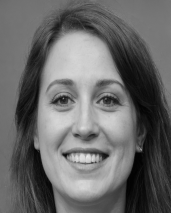

In [6]:
#Aquí pueden cambiar el número que está dentro de [] y ver las imágenes y su tamaño
print('Imágen perteneciente al conjunto de validación')
cv2_imshow(valdata['Img'][0])

Imágen perteneciente al conjunto de entrenamiento


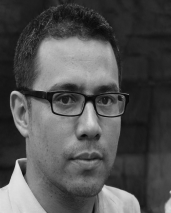

In [7]:
print('Imágen perteneciente al conjunto de entrenamiento')
cv2_imshow(trndata['Img'][0])

## ENTRENAMIENTO DEL MODELO

Para este modelo, se plantea una red convolucional sequencial (por capas), con 19 capas, funciones de activación Relu y Lineal, kernel de tamaño 3x3 y capas con 32, 64 y 128 neuronas. Cómo última función de activación, se tiene sigmoide ya que ésta es mejor para problemas de clasificación binaria.

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(213,171,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(32, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(32, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(2, activation='sigmoid'))

Luego, se compila el modelo con algoritmo de optimización en la tasa de aprendizaje, adam, función de perdida binary crossentropy y exactittud como métrica.

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Se extraen las imágenes (np.arrays) de los dataframes previamente creado para ingresarlos al modelo.

In [10]:
x_train=np.array(trndata['Img'].to_list(), dtype=np.float64)
y_train=trndata['Glasses']
x_val=np.array(valdata['Img'].to_list(), dtype=np.float64)
y_val=valdata['Glasses']

Y se entrena el modelo guardando un historial de entrenamiento.

In [11]:
history=model.fit(x_train, pd.get_dummies(y_train).values , epochs=20, validation_data=(x_val, pd.get_dummies(y_val).values), batch_size=64)

Epoch 1/20
26/26 [==============================] - 20s 133ms/step - loss: 1.5773 - accuracy: 0.5367 - val_loss: 0.6406 - val_accuracy: 0.6121
Epoch 2/20
26/26 [==============================] - 2s 87ms/step - loss: 0.6248 - accuracy: 0.6741 - val_loss: 0.4661 - val_accuracy: 0.8727
Epoch 3/20
26/26 [==============================] - 2s 87ms/step - loss: 0.3260 - accuracy: 0.8768 - val_loss: 0.1340 - val_accuracy: 0.9616
Epoch 4/20
26/26 [==============================] - 2s 88ms/step - loss: 0.1530 - accuracy: 0.9458 - val_loss: 0.0451 - val_accuracy: 0.9859
Epoch 5/20
26/26 [==============================] - 2s 88ms/step - loss: 0.0962 - accuracy: 0.9649 - val_loss: 0.0178 - val_accuracy: 0.9960
Epoch 6/20
26/26 [==============================] - 2s 87ms/step - loss: 0.0742 - accuracy: 0.9747 - val_loss: 0.0196 - val_accuracy: 0.9960
Epoch 7/20
26/26 [==============================] - 2s 87ms/step - loss: 0.0457 - accuracy: 0.9809 - val_loss: 0.0136 - val_accuracy: 0.9980
Epoch 8/20


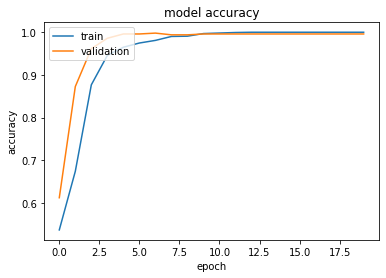

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

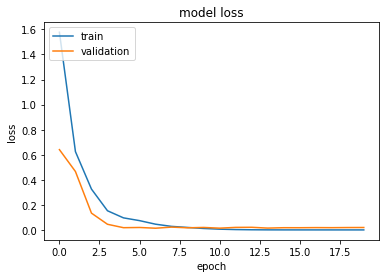

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
#Guardado del modelo
model.save('/content/drive/MyDrive/Trabajos/Trabajo 3/Código_Python/modelo.h5')